In [48]:
import ngmix
import matplotlib.pyplot as plt
import galsim
import numpy as np

def select(data, shear_type):
    """
    select the data by shear type and size
    Parameters
    ----------
    data: array
        The array with fields shear_type and T
    shear_type: str
        e.g. 'noshear', '1p', etc.
    Returns
    -------
    array of indices
    """

    w, = np.where(
        (data['flags'] == 0) & (data['shear_type'] == shear_type)
    )
    return w

def make_struct(res, obs, shear_type):
    """
    make the data structure
    Parameters
    ----------
    res: dict
        With keys 's2n', 'e', and 'T'
    obs: ngmix.Observation
        The observation for this shear type
    shear_type: str
        The shear type
    Returns
    -------
    1-element array with fields
    """
    dt = [
        ('flags', 'i4'),
        ('shear_type', 'U7'),
        ('s2n', 'f8'),
        ('g', 'f8', 2),
        ('T', 'f8'),
        ('Tpsf', 'f8'),
    ]
    data = np.zeros(1, dtype=dt)
    data['shear_type'] = shear_type
    data['flags'] = res['flags']
    if res['flags'] == 0:
        data['s2n'] = res['s2n']
        # for moments we are actually measureing e, the elliptity
        data['g'] = res['e']
        data['T'] = res['T']
    else:
        data['s2n'] = np.nan
        data['g'] = np.nan
        data['T'] = np.nan
        data['Tpsf'] = np.nan

        # we only have one epoch and band, so we can get the psf T from the
        # observation rather than averaging over epochs/bands
        data['Tpsf'] = obs.psf.meta['result']['T']
    return data


In [107]:
def make_data(rng, noise, shear):
    """
    simulate an exponential object with moffat psf
    Parameters
    ----------
    rng: np.random.RandomState
        The random number generator
    noise: float
        Noise for the image
    shear: (g1, g2)
        The shear in each component
    Returns
    -------
    ngmix.Observation
    """

    scale    = 0.263
    psf_fwhm = 0.9
    gal_hlr  = 0.5
    dy, dx   = rng.uniform(low=-scale/2, high=scale/2, size=2)

    psf = galsim.Moffat(beta=2.5, fwhm=psf_fwhm,
    ).shear(g1=0.02, g2=-0.01,)
    
    
    obj0 = galsim.Exponential(
        half_light_radius=gal_hlr,
    ).shear(
        g1=shear[0],
        g2=shear[1],
    ).shift(
        dx=dx,
        dy=dy,
    )
    obj = galsim.Convolve(psf, obj0)

    psf_im = psf.drawImage(scale=scale).array
    im = obj.drawImage(scale=scale).array

    # psf noise
    psf_noise= .001
    psf_im += rng.normal(scale=psf_noise, size=psf_im.shape)
    im += rng.normal(scale=noise, size=im.shape)
    
    cen = (np.array(im.shape)-1.0)/2.0
    psf_cen = (np.array(psf_im.shape)-1.0)/2.0
    jacobian = ngmix.DiagonalJacobian(
        row=cen[0] + dy/scale, col=cen[1] + dx/scale, scale=scale,
    )
    psf_jacobian = ngmix.DiagonalJacobian(
        row=psf_cen[0], col=psf_cen[1], scale=scale,
    )

    # noise variance map
    wt     = im*0 + 1.0/noise**2
    psf_wt = psf_im*0 + 1.0/psf_noise**2

    psf_obs = ngmix.Observation(
        psf_im,
        weight=psf_wt,
        jacobian=psf_jacobian,
    )
    obs = ngmix.Observation(
        im,
        weight=wt,
        jacobian=jacobian,
        psf=psf_obs,
    )
    return obs

In [108]:
rng = np.random.RandomState(1024)
# We will measure moments with a fixed gaussian weight function
weight_fwhm= 1.2
fitter     = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)
psf_fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)

# these "runners" run the measurement code on observations
psf_runner = ngmix.runners.PSFRunner(fitter=psf_fitter)
runner     = ngmix.runners.Runner(fitter=fitter)

# this "bootstrapper" runs the metacal image shearing as well as both psf
# and object measurements
#
# We will just do R11 for simplicity and to speed up this example;
# typically the off diagonal terms are negligible, and R11 and R22 are
# usually consistent
boot      = ngmix.metacal.MetacalBootstrapper(
    runner= runner, psf_runner=psf_runner,
    rng=rng,
    psf='gauss',
    types=['noshear', '1p', '1m'],
)

In [115]:
# simulate 100 galaxies
# and put them into a list
obs_list=[]
shear_true = [0.1, 0.00]
for i in range(100):
    _obs = make_data(rng=rng, noise=.001, shear=shear_true)
    obs_list.append(_obs)
    del _obs

CPU times: user 4.41 s, sys: 311 ms, total: 4.72 s
Wall time: 4.78 s


Text(0, 0.5, 'g_measured')

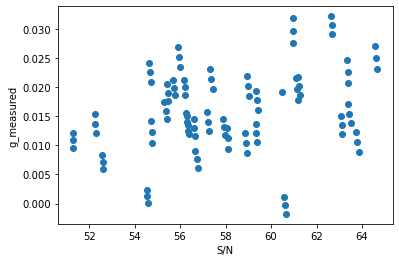

In [119]:
%%time
dlist = []
for i in range(100):
    obs = obs_list[i]
    resdict, obsdict = boot.go(obs)
    for stype, sres in resdict.items():
        st = make_struct(res=sres, obs=obsdict[stype], shear_type=stype)
        dlist.append(st)

data = np.hstack(dlist)
#print(data)


x = []
y = []



for i in range(100):
    s2n = data['s2n'][i]
    x.append(s2n)
    
    m = shear[0]/shear_true[0]-1
    c = shear[1]
    g = data['g'][i, 0]
    #g = shear[0]
    
    g_meas = (1+m)*g + c
    y.append(g_meas)
    #s2n = data['s2n'][i]
    
    #x.append(s2n)
    #y.append(g_meas)
    
#print(x)
#print(y)
plt.scatter(x, y)
plt.xlabel("S/N")
plt.ylabel("g_measured")

In [117]:
w = select(data=data, shear_type='noshear')
w_1p = select(data=data, shear_type='1p')
w_1m = select(data=data, shear_type='1m')

g    = data['g'][w].mean(axis=0)
gerr = data['g'][w].std(axis=0) / np.sqrt(w.size)
g1_1p= data['g'][w_1p, 0].mean()
g1_1m= data['g'][w_1m, 0].mean()
R11  = (g1_1p - g1_1m)/0.02

shear= g / R11
shear_err = gerr / R11

m    = shear[0]/shear_true[0]-1
merr = shear_err[0]/shear_true[0]

s2n  = data['s2n'][w].mean()

print('S/N: %g' % s2n)
print('R11: %g' % R11)
print('m: %g +/- %g (99.7%% conf)' % (m, merr*3))
print('c: %g +/- %g (99.7%% conf)' % (shear[1], shear_err[1]*3))
#g_meas = (1+m)g + c

S/N: 57.7417
R11: 0.160095
m: -0.000943014 +/- 0.121271 (99.7% conf)
c: 0.00163489 +/- 0.0115264 (99.7% conf)
